# Data exploration on AffectNet raw dataset

In this notebook are shown the main features of the dataset and the distribution of the data fot the AffectNet dataset (concretly the AffectNet8Labels a reduced version from full). The generated interim dataset from the raw data will be used to perform the data exploration, as in this format it will be easier to compute the necessary operations.

First I will import the necessary libraries and load the dataset and see an example of the data and its general annotations. Afterwards, I will perform a data sanity check to avoid having issues latter on. Then I will see the distribution of the data in the dataset and the distribution of the annotations in general. Finally, I will analyze it in more detail for each data split given and for each original db. Here is the main schematic of the data exploration:
* 0. Interim data loading
* 1. Data sanity check
* 2. Data exploration over all data
* 3. Data exploration over each split
* 4. Conclusions

**Note**: For visualizations I used *blue* to denote quantities or counts and *yellow* to show probabilities or normalized values*

# 0. Interim data loading
First I declare the necessary variables and import the necessary libraries.

In [199]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import Image
import sys

import altair as alt
alt.data_transformers.disable_max_rows() # delete the upper bound of entries in altair
alt.renderers.enable("html") # enable altair to render in html
# Suppress AltairDeprecationWarning warnings
import warnings
from altair.utils.deprecation import AltairDeprecationWarning
warnings.filterwarnings("ignore", category=AltairDeprecationWarning)

from prettytable import PrettyTable

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import INTERIM_AFFECTNET_DIR, INTERIM_COLUMNS_AFFECTNET, AFFECTNET_CAT_EMOT
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

Now we load the interim dataset:

In [200]:
annotations_path = Path(os.path.join(INTERIM_AFFECTNET_DIR, 'annotations'))

annotations = {}
for data_split in os.listdir(annotations_path):
    if data_split.endswith('.pkl'):
        file = os.path.join(annotations_path, data_split)
        data_part_name = data_split.split('_')[0]
        annotations[data_part_name] = pd.read_pickle(file)

# Sort the dictionary based on the order_list
desired_datasplit_order = ['train', 'val']
annotations = dict(sorted(annotations.items(), key=lambda x: desired_datasplit_order.index(x[0])))
print("The annotations found are for the datasplits:", list(annotations.keys()))

The annotations found are for the datasplits: ['train', 'val']


Now we see some rows of the train interim dataset:

In [201]:
annotations['train'].head()

,path,cat_emot,valence,arousal
0,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,0,-0.392238,-0.192678
1,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,3,0.303845,0.557880
2,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,1,0.479094,0.077429
3,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,1,0.787009,0.358637
4,/mnt/gpid08/datasets/affectnet/raw/train_set/i...,3,-0.015873,0.626984


# 1. Data sanity check
Now I will perform a sanity check on the data to see if there are any issues with it. I will check that columns are equal to standard:

In [202]:
# Check if the vectors are equal
if np.array_equal(annotations['train'].columns, INTERIM_COLUMNS_AFFECTNET):
    print("The columns are equal to standard in the train split")
else:
    print("The columns are not equal to standard in the val split")

# Check if the vectors are equal
if np.array_equal(annotations['val'].columns, INTERIM_COLUMNS_AFFECTNET):
    print("The columns are equal to standard in the val split")
else:
    print("The columns are not equal to standard in the val split")

The columns are equal to standard in the train split
The columns are equal to standard in the val split


Now check that data types are correct:

In [203]:
for data_split, df in annotations.items():
    print(f"Data Split: {data_split}")
    print(df.dtypes)
    print()


Data Split: train
path         object
cat_emot      int64
valence     float64
arousal     float64
dtype: object

Data Split: val
path         object
cat_emot      int64
valence     float64
arousal     float64
dtype: object



And finally check that there are not null or NaN values:

In [204]:
for data_split, df in annotations.items():
    print(f"Data Split: {data_split}")
    print(df.isnull().sum())
    print()


Data Split: train
path        0
cat_emot    0
valence     0
arousal     0
dtype: int64

Data Split: val
path        0
cat_emot    0
valence     0
arousal     0
dtype: int64



Not null values are present, so the data sanity is correct. I can now proceed to the data exploration.

# 2. Data exploration over all data
First I will see the distribution of the data over all data splits. This way we can confirm how annotations are distributed over the whole dataset and then observe how many. I will see the distribution of the data in the following ways:
* 2.1 Continuous emotions
* 2.2 Categorical emotions
* 2.3 Continuous emotions conditioned to categorical emotions
* 2.4 Image size distribution

**AffectNet paper sum-up for out project:**

According to the AffectNet paper, all photos where queried from the web. Emotion-related keywords were combined with words related to gender, age, or ethnicity, to obtain nearly 362 strings in the English language such as “joyful girl”, “blissful Spanish man”, “furious young lady”, “astonished
senior”. These keywords are then translated into five other languages: Spanish, Portuguese, German, Arabic and Farsi using native speakers and inspeceted the results visually. The way to select high quality-queries was done by selecting the ones that returned a high percentage of humans faces. A total of 1250 queries was done, and as many returned neutral faces, no individual query was done. 

They used Google, Bing and Yahoo engines and added to the query negative terms (drawing, cartoon,...) to avoid non-human objects as much as possible. Also sotck phortos were filtered out (this way they avoid watermarks and unnatural emotions or poses). The OpenCV library was used to detect faces in the images. 

The average estimated age of the faces is 33.01 years with the standard deviation of 16.96 years. In particular, 10.85, 3.9, 30.19, 26.86, 14.46, and 13.75 percent of the faces are in age ranges [0, 10), [10, 20), [20, 30), [30, 40), [40, 50) and [50, -), respectively. MS face API (for face-keypoint generation that we are not interested in) detected forehead, mouth, and eye occlusions in 4.5, 1.08, and 0.49 percent of the images, respectively. Also, 9.63% of the faces wear glasses, 51.07 and 41.4% of the faces have eye and lip make-ups, respectively.In terms of head pose, the average estimated pitch, yaw, roll are 0.0,-0.7, and -1.19 degrees, respectively (that is the head is slightly tilted to the left).

For annotating AffecNet creators hired 12 full-time and parttime expert annotators at the University of Denver to label the database. A software application was created to annotate valence and arousal and the categorical emotion. The image bellow (Figure 2 in paper) shows an example of the annotation application. For each of the annotators a tutorial was given for each one of them, and three training sessions were given to each one (annotatin 200 images and then analyzing then reviewing th results and feedback). Also an occlusion criterion was defined. If the person in the images wore glasses, but the eyes were visible without any shadow, it was not considered as occlusion.

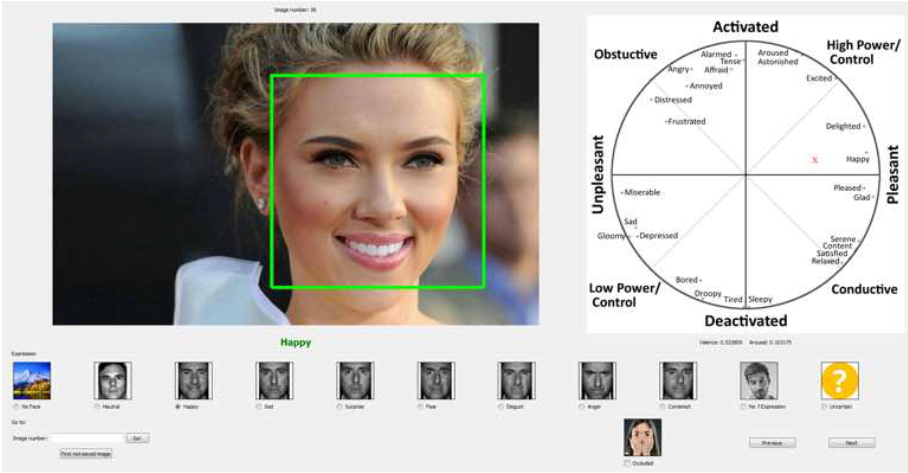

To model the continuous annotations, they have created a 2D Cartesian coordinate system where the x-axis and y-axis represent the valence and arousal. The annotation software did not allow the value of valence and arousal outside of the circumplex (of radius 1). This allows to convert the Cartesian coordinates to polar coordinates with $r$ inside $0\leq r\leq 1$ and $\theta$ inside $0 \leq \theta < 360$.  Morover, a predefined region is defined for each categorical emotion in the annotation software (e.g., for happy emotion the valence is in (0.0, 1.0], and the arousal is in [-0.2, 0.5] ). If the annotators decided to choose a value outside of the selected emotion’s region, the annotation software showed a warning and it could only be there if they were sure. Also it was set a flag to be able to be reviewed by the authors. This helped to avoid mistakes in the annotation of the dimensional model.

Finally to know the measure of agreement between the annotators, 36,000 images were annotated by two annotators. The annotations were performed fully blind and independently. The results showed that the annotators agreed on 60.7% of the images.

Now I will compute the joint data distribution across all splits, this way we can analyze the distribution of the data in general.

In [205]:
joint_annotations = pd.concat([annotations['train'], annotations['val']], ignore_index=True)

## 2.1 Continuous emotions
First I will start by analyzing the distribution of the continuous emotions. In this case there are two main variables, they are arousal and valence. 
1. ``Valence``: The negativity/positivity of the emotion felt. It is a value between -1 and 1, where -1 is the most negative valence and 1 is the most positive valence.
2. ``Arousal``: The intensitivity of the emotion felt. It is a value between -1 and 1, where -1 is the most calm and 1 is the most excited emotion.

Both draw a unit circle around 0,0 (following the AffectNet paper information), where "x" is the valence and "y" is the arousal. Now I will analyze the main statistics for the distribution of continuous emotions:

In [206]:
valence_stats = {
    'Continuous emotion:': 'Valence',
    'Max': round(joint_annotations['valence'].max(), 2),
    'Min': round(joint_annotations['valence'].min(), 2),
    'Mean': round(joint_annotations['valence'].mean(), 2),
    'Q1': round(joint_annotations['valence'].quantile(0.25), 2),
    'Q2 (Median)': round(joint_annotations['valence'].median(), 2),
    'Q3': round(joint_annotations['valence'].quantile(0.75), 2)
}

arousal_stats = {
    'Continuous emotion:': 'Arousal',
    'Max': round(joint_annotations['arousal'].max(), 2),
    'Min': round(joint_annotations['arousal'].min(), 2),
    'Mean': round(joint_annotations['arousal'].mean(), 2),
    'Q1': round(joint_annotations['arousal'].quantile(0.25), 2),
    'Q2 (Median)': round(joint_annotations['arousal'].median(), 2),
    'Q3': round(joint_annotations['arousal'].quantile(0.75), 2)
}

# Create dataframes from the statistics dictionaries
arousal_stats_df = pd.DataFrame(arousal_stats, index=['Arousal'])
valence_stats_df = pd.DataFrame(valence_stats, index=['Valence'])

# Concatenate the dataframes
statistics_df = pd.concat([arousal_stats_df, valence_stats_df])

# Create a pretty table
table = PrettyTable()
table.field_names = statistics_df.columns

# Add rows to the table
for index, row in statistics_df.iterrows():
    table.add_row(row)

# Display the table
print(table)

+---------------------+-----+-------+------+-------+-------------+------+
| Continuous emotion: | Max |  Min  | Mean |   Q1  | Q2 (Median) |  Q3  |
+---------------------+-----+-------+------+-------+-------------+------+
|       Arousal       | 1.0 | -0.97 | 0.12 | -0.06 |     0.07    | 0.24 |
|       Valence       | 1.0 |  -1.0 | 0.18 | -0.19 |     0.19    | 0.65 |
+---------------------+-----+-------+------+-------+-------------+------+


We can observe that both of the emotions are continuous and have a range of almost [-1, 1]. The mean of both the emotions is close to 0.1 (arousal) and 0.2 (valence), which means that the dataset will have a bias to predict positive emotions with litle excitement.

From the raw data exploration, in the paper we had seen that non-face had a value -2 in both arousal and valence. But as it's not present any value lower than -1 we will see later on if they are in the categorical emotions.

Now I will show the distribution of the continuous emotions in the dataset:

In [207]:
# Define the bin size
number_of_bins = 10 

# Compute the histogram
hist_valence, intervals = np.histogram(joint_annotations['valence'], bins=number_of_bins, range=[-1,1])
hist_arousal, _ = np.histogram(joint_annotations['arousal'], bins=number_of_bins, range=[-1,1])

# Compute middle points
mid_points = [(intervals[i] + intervals[i+1])/2 for i in range(len(intervals)-1)]

# Create a pandas DataFrame
hist_valence_df = pd.DataFrame({'count': hist_valence, 'valence': mid_points})
hist_arousal_df = pd.DataFrame({'count': hist_arousal, 'arousal': mid_points})

In [208]:
# Compute the mean for valence and arousal
valence_mean = valence_stats['Mean']; arousal_mean = arousal_stats['Mean']

# Create a histogram with mean line for valence
valence_hist = alt.Chart(hist_valence_df).mark_bar(color="steelblue", width=20).encode(
    x = alt.X("valence:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(values = intervals, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y = alt.Y('count:Q', title = 'Count of records'),
    tooltip = [alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Valence Distribution', fontSize=16),
    width=300,
    height=400
)
# Create a histogram with mean line for arousal
arousal_hist = alt.Chart(hist_arousal_df).mark_bar(color="steelblue", width=20).encode(
    x = alt.X("arousal", bin=alt.Bin(maxbins=10), axis=alt.Axis(values = intervals, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    y = alt.Y('count:Q', title = 'Count of records'),
    tooltip = [alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Arousal Distribution', fontSize=16),
    width=300,
    height=400
)


# Add mean line for valence
valence_mean_line = alt.Chart(pd.DataFrame({'mean': [valence_mean]})).mark_rule(color='black', size = 3).encode(
    x='mean'
)

valence_mean_text = alt.Chart(pd.DataFrame({'mean': [valence_mean]})).mark_text(
    align='right', dx=-5, dy = -180
).encode(
    x='mean',
    text=alt.value('Mean: ' + str(valence_mean))
)

# Add mean line for arousal
arousal_mean_line = alt.Chart(pd.DataFrame({'mean': [arousal_mean]})).mark_rule(color='black', size = 3).encode(
    x='mean'
)

arousal_mean_text = alt.Chart(pd.DataFrame({'mean': [arousal_mean]})).mark_text(
    align='right', dx=-5, dy = -180
).encode(
    x='mean',
    text=alt.value('Mean: ' + str(arousal_mean))
)

# Concatenate the histograms and mean lines horizontally
combined_chart = alt.hconcat(
    (valence_hist + valence_mean_line + valence_mean_text), 
    (arousal_hist + arousal_mean_line + arousal_mean_text)
).resolve_scale(y='shared').properties(
    title=alt.TitleParams(text="Continuous annotations distributions", anchor='middle', fontSize=20, dy=-20),
)

combined_chart

alt.HConcatChart(...)

We can observe how the data is distributed by the continuous emotions. We can see that the data is more concentrated in the positive emotions (valence > 0) and in the excited emotions (arousal > 0). This means that the dataset will have a bias to predict positive emotions with little excitement. Regarding the uniformity of the distribution, arousal shows a better uniformity than valence, which is more concentrated around the middle (with a huge spike around [0-0.2] interval) and more weight in the positive sector. We can also observe that there is almost no value around -1.0 and -0.8. 

Now I will create a heatmap (representing a 2d histogram where color encodes the count) similar to the one that is shown in the paper to see if the results are similar. First I will create a function to create the heatmap:

In [209]:
# Define the general heatmap parameters
total_bins = 40
step_size = 0.25; num_steps = 7
axis_steps= np.arange(-1, 1+step_size, step_size); bin_edges = np.linspace(-1, 1, total_bins+1)  
# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations['valence'], 
    joint_annotations['arousal'], 
    bins=[bin_edges, bin_edges]
)

Convert to pandas to proper display.

In [210]:
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

Define the max value of the plot to set the color range. 

In [211]:
# Find the maximum count
max_count = hist.max()
legend_steps = np.linspace(0, max_count, num=num_steps).astype(int)
legend_steps_log = np.logspace(np.log10(1), np.log10(max_count), num_steps).astype(int)

Add dotted lines to help to identify regions. 

In [212]:
# Now add the dotted grid lines:
axis_steps_middle = axis_steps [1:-1] # remove the first and last element of the grid
new_step_size = step_size/10 # define the new step size for plotting the points
axis_steps_middle2 = np.arange(-1+new_step_size, 1, new_step_size)
grid_points = pd.DataFrame({ # create a dataframe with the grid points
    'valence': np.concatenate((np.repeat(axis_steps_middle, len(axis_steps_middle2)), np.tile(axis_steps_middle2, len(axis_steps_middle)))),
    'arousal': np.concatenate((np.tile(axis_steps_middle2, len(axis_steps_middle)), np.repeat(axis_steps_middle, len(axis_steps_middle2))))
})

Create the plots:

In [213]:
# Create the histogram using Altair
histogram_2d_linear = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (linear-scale)", values=legend_steps)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    width=400,
    height=400
)
# Create the dotted grid using mark_circle
dotted_grid = alt.Chart(grid_points).mark_circle(
    size=5, color='black', opacity=0.4
).encode(
    x=alt.X('valence:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False)),
    y=alt.Y('arousal:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False))
)

# Overlay the heatmap and the dotted grid
histogram_2d_with_dotted_grid_linear = (dotted_grid + histogram_2d_linear).properties(title = 'Linear scale').interactive()

In [214]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=400,
    height=400
)
# Overlay the heatmap and the dotted grid
histogram_2d_with_dotted_grid_log = (dotted_grid + histogram_2d_log).properties(title = 'Logarithmic scale').interactive()

In [215]:
combined_chart = alt.hconcat(histogram_2d_with_dotted_grid_linear, 
histogram_2d_with_dotted_grid_log).resolve_scale(color='independent').resolve_legend(color='independent'
                            ).properties(title= alt.Title("Valence/Arousal distribution with different color scales", anchor='middle', fontSize=20, dy=-20))
combined_chart

alt.HConcatChart(...)

In the linear scale it is hard to observe the distribution of the data, only it can be seen a huge spike around the middle and some relevant sectors around positive/negative valences and middle arousals. For the log scale the distribution is more clear, we can observe that the data is more concentrated in the middle with some patterns from the middle to outside the circle. If we compare to the figure provided by the paper (Fig.4), the same patterns can be observed in general (good signal as the data is distributed in the same way). In section 2.3 I will focus on analyzing the regions for each categorical emotion.  

Nonetheless, if we focus our attention on the plots, we can observe little differences. More notorious around the values lower than -0.8 in arousal. There is missing rows, so we need to see how many values are missing.

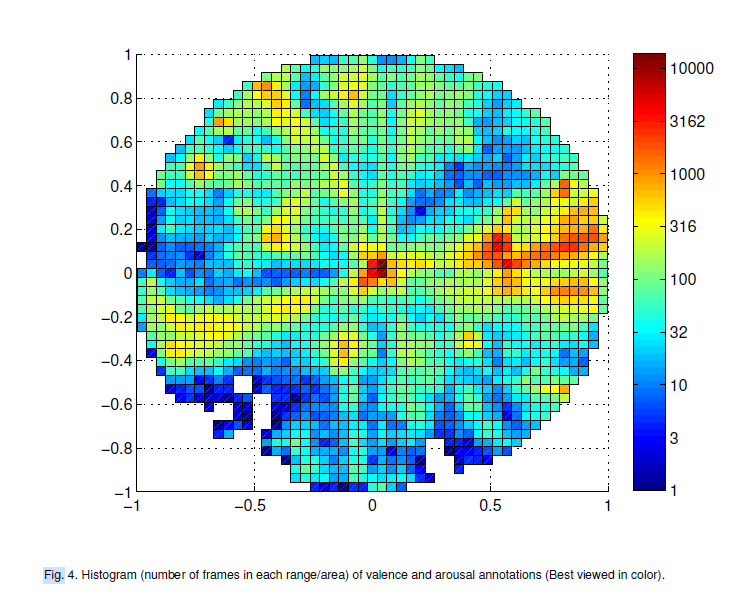

Now I will compare to given table by the paper (Table 14) where it is shown all the counts for each bin (of length 0.2 for each dimension). First we compute the values for the loaded dataset. We will use the same bins as in the paper and show it in a table:

In [216]:
# Define the general heatmap parameters
total_bins = 10
bin_edges = np.linspace(-1, 1, total_bins+1)  
# Calculate the 2D histogram
hist, arousal_edges, valence_edges = np.histogram2d(
    joint_annotations['arousal'], 
    joint_annotations['valence'], 
    bins=[bin_edges, bin_edges]
)

valence_edges = np.round(valence_edges, 1); arousal_edges = np.round(arousal_edges, 1)

# Create a table
table = PrettyTable()
# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(hist[i, j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)
# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |     0.0     |     0.0     |    2538.0   |    1228.0   |   3407.0   |   1445.0  |   1289.0  |   494.0   |    0.0    |    0.0    |
|    0.8 - 0.6    |     0.0     |    2560.0   |    6059.0   |    3475.0   |   3978.0   |   2127.0  |   2902.0  |   623.0   |   533.0   |    0.0    |
|    0.6 - 0.4    |    468.0    |    6389.0   |    1741.0   |    2967.0   |   1599.0   |   1872.0  |   1263.0  |   329.0   |   832.0   |   405.0   |
|    0.4 - 0.2    |    454.0    |    862.0    |    2835.0   |    4969.0   |   1755.0   |   648.0   |   241

Now we will compare to the annotated oimages in the original paper (Table 14), the values are shown in the following table:

In [217]:
# Convert the table to a 2D numpy array
paper_histogram = np.array([
    [0, 0, 21, 674, 1021, 521, 60, 57, 0, 0],
    [0, 74, 161, 561, 706, 1006, 432, 738, 530, 0],
    [638, 720, 312, 505, 2689, 1905, 1228, 992, 3891, 957],
    [6770, 9283, 3884, 2473, 5530, 2296, 3506, 1824, 2667, 1125],
    [3331, 1286, 2971, 4854, 14083, 15300, 4104, 9998, 13842, 9884],
    [395, 577, 5422, 3675, 9024, 23201, 6237, 42219, 23281, 21040],
    [787, 1364, 3700, 6344, 2804, 1745, 821, 5241, 10619, 9934],
    [610, 7800, 2645, 3571, 2042, 2517, 1993, 467, 1271, 921],
    [0, 3537, 8004, 4374, 5066, 3379, 4169, 944, 873, 0],
    [0, 0, 4123, 1759, 4836, 1845, 1672, 739, 0, 0]
])

# Create table
table = PrettyTable()
# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(paper_histogram[i, j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)
# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |      0      |      0      |     4123    |     1759    |    4836    |    1845   |    1672   |    739    |     0     |     0     |
|    0.8 - 0.6    |      0      |     3537    |     8004    |     4374    |    5066    |    3379   |    4169   |    944    |    873    |     0     |
|    0.6 - 0.4    |     610     |     7800    |     2645    |     3571    |    2042    |    2517   |    1993   |    467    |    1271   |    921    |
|    0.4 - 0.2    |     787     |     1364    |     3700    |     6344    |    2804    |    1745   |    82

Finally we compute the difference and show it in a table:

In [218]:
# Create a table
table = PrettyTable()
# Set the column names
table.field_names = ['Arousal/Valence'] + [f'{arousal_edges[i]} - {arousal_edges[i+1]}' for i in range(len(arousal_edges)-1)]

# Add rows to the table
for i in range(len(valence_edges)-2, -1, -1):
    row = [f'{arousal_edges[i+1]} - {valence_edges[i]}'] + [str(paper_histogram[i, j]-hist[i,j]) for j in range(len(arousal_edges)-1)]
    table.add_row(row)
# Print the table
print(table)

+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
| Arousal/Valence | -1.0 - -0.8 | -0.8 - -0.6 | -0.6 - -0.4 | -0.4 - -0.2 | -0.2 - 0.0 | 0.0 - 0.2 | 0.2 - 0.4 | 0.4 - 0.6 | 0.6 - 0.8 | 0.8 - 1.0 |
+-----------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+-----------+-----------+-----------+
|    1.0 - 0.8    |     0.0     |     0.0     |    1585.0   |    531.0    |   1429.0   |   400.0   |   383.0   |   245.0   |    0.0    |    0.0    |
|    0.8 - 0.6    |     0.0     |    977.0    |    1945.0   |    899.0    |   1088.0   |   1252.0  |   1267.0  |   321.0   |   340.0   |    0.0    |
|    0.6 - 0.4    |    142.0    |    1411.0   |    904.0    |    604.0    |   443.0    |   645.0   |   730.0   |   138.0   |   439.0   |   516.0   |
|    0.4 - 0.2    |    333.0    |    502.0    |    865.0    |    1375.0   |   1049.0   |   1097.0  |   580

But as it is hard to compare the results, I will show it using a heatmap (similarly to the one I did before but with 0.2 bin size):

In [219]:
hist_df_difference = pd.DataFrame(
    [(x, y, int(paper_histogram[i, j]-hist[i,j])) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['arousal', 'valence', 'count']
)
# Delete entries where count is equal to 0
hist_df_difference = hist_df_difference.query('count != 0')

In [220]:
# Create the histogram using Altair
difference_histogram_2d = alt.Chart(hist_df_difference).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=valence_edges, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=arousal_edges, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    width=400,
    height=400
)

# Overlay the heatmap and the dotted grid
difference_histogram_2d_with_dotted_grid = (difference_histogram_2d).properties(title = 'Number of missing data with respect to paper').interactive()
difference_histogram_2d_with_dotted_grid

alt.Chart(...)

We can observe that the loss in data is generalized around all the table. But to get a sense on how much data is lost per sector, I will normalize the data to the given table and show it in a heatmap:

In [221]:
hist_df_difference_normed = pd.DataFrame(
    [(x, y,(paper_histogram[i, j]-hist[i,j]), (paper_histogram[i, j]-hist[i,j])/paper_histogram[i, j]) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['arousal', 'valence', 'count', 'percentage'])

# Delete entries where count is equal to NaN
hist_df_difference_normed = hist_df_difference_normed.dropna(subset=['percentage'])

/tmp/ipykernel_707142/154834002.py:2: RuntimeWarning: invalid value encountered in scalar divide
  [(x, y,(paper_histogram[i, j]-hist[i,j]), (paper_histogram[i, j]-hist[i,j])/paper_histogram[i, j]) for i, x in enumerate(arousal_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],


In [222]:
# Create the histogram using Altair
difference_histogram_2d = alt.Chart(hist_df_difference_normed).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=valence_edges, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=arousal_edges, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('percentage:Q', scale=alt.Scale(scheme='darkgold', domain=[0, 1.05]), 
                    legend=alt.Legend(title="Count of records")),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('percentage:Q', title = 'Percentage of missing data'),
        alt.Tooltip('count:Q', title = 'Count of missing records')
    ]
).properties(
    width=400,
    height=400
)

# Overlay the heatmap and the dotted grid
difference_histogram_2d_with_dotted_grid = (difference_histogram_2d).properties(title = 'Percentage of missing data with respect to paper').interactive()
difference_histogram_2d_with_dotted_grid

alt.Chart(...)

We can observe that most data (around 90%) is lost under -0.8 in valence as it was observed before, and some peaks around the table. But as the numbers are very small, I expect to have little impact on general model behaviour. Only the lower arousal values will be hard to predict as there is little information about them. 

## 2.2 Categorical emotions
Now I will follow my analysis with categorical emotions, these can be felt disjointly (so one face can only feel one emotion). As I have the reduced dataset, I expect only to have 8 emotions:
* 0: Neutral
* 1: Happy
* 2: Sad 
* 3: Surprise
* 4: Fear
* 5: Disgust 
* 6: Anger
* 7: Contempt (antipahty, disgust, or hatred)

The simplest distinction between them is that disgust is usually about physical objects (e.g., rotten food), whereas contempt is about human characteristics (e.g., incompetence). The None (“None of the eight emotions”) category is the type of expression/emotions (such as sleepy, bored, tired, seducing, confuse, shame, focused, etc.)

The annotation process was done by selecting the proper experssion category, where the intensity is not relevant. According to the paper, the majority of the returned images from the search engines were happy or neutral faces. The authors believe that this is because people tend to publish their images with positive expressions rather than negative expressions. This tells us the dataset is biased towards positive emotions.

Now I will analyze the main statistics for the distribution of categorical emotions, first I will show the distribution of the categorical emotions in the dataset:

In [223]:
counts = joint_annotations['cat_emot'].value_counts().reset_index()
counts['cat_emot_label'] = counts['cat_emot'].map(dict(enumerate(AFFECTNET_CAT_EMOT)))

In [224]:
# Create a histogram with mean line for valence
cat_emot_bar_plot = alt.Chart(counts).mark_bar(color="steelblue", width=20).encode(
    alt.X("cat_emot_label:N", sort='-y', 
          axis=alt.Axis(labelAngle=0, title="Categorical emotions", labelFlush=False)),
    alt.Y('count:Q', title = 'Count of records'),
    tooltip=[
        alt.Tooltip('cat_emot_label:N', title='Categorical emotion'),
        alt.Tooltip('count:Q', title = 'Count of records')]
).properties(
    title=alt.TitleParams(text='Categorical emotions distribution', fontSize=16),
    width=400,
    height=400
)

cat_emot_bar_plot.interactive()

alt.Chart(...)

As it can bee observed, the dataset is biased towards positive emotions, with a huge amount of neutral and happy faces. This means that the dataset will have a bias to predict positive emotions. The least represented emotions are contempt and disgust, which are the most negative emotions. This means that the dataset will has a bias towards positive emotions with little negativity.

Now I compare these results with the given by the paper. The paper shows the following table (table 3 in paper):

In [225]:
expression_reference_dict = {
    "Neutral": 80276,
    "Happy": 146198,
    "Sad": 29487,
    "Surprise": 16288,
    "Fear": 8191,
    "Disgust": 5264,
    "Anger": 28130,
    "Contempt": 5135,
    "None": 35322,
    "Uncertain": 13163,
    "Non-Face": 88895
}

Now I compute the difference: 

In [226]:
# Compute the difference between reference and computed histogram on categorical emotions
difference_count = []
for cat_emot in expression_reference_dict.keys():
    if cat_emot in counts['cat_emot_label'].values:
        row = counts[counts['cat_emot_label'] == cat_emot]
        count = row['count'].values[0]
        difference = expression_reference_dict[cat_emot] - count
        difference_count.append({'cat_emot_label': cat_emot, 'difference': difference})
    else:
        difference_count.append({'cat_emot_label': cat_emot, 'difference': expression_reference_dict[cat_emot]})

# Create a new dataframe with the difference
difference_df = pd.DataFrame(difference_count)

# Print the dataframe
print(difference_df)

   cat_emot_label  difference
0         Neutral        4902
1           Happy       11283
2             Sad        3528
3        Surprise        1698
4            Fear        1313
5         Disgust         961
6           Anger        2748
7        Contempt         886
8            None       35322
9       Uncertain       13163
10       Non-Face       88895


As it is hard to compare the results, I will show it using a bar chart:

In [227]:
# Create a histogram with mean line for valence
cat_emot_bar_plot = alt.Chart(difference_df).mark_bar(color="steelblue", width=20).encode(
    alt.X("cat_emot_label:N", sort='-y', 
          axis=alt.Axis(labelAngle=0, title="Categorical emotions", labelFlush=False)),
    alt.Y('difference:Q', title = 'Count of missing records'),
    tooltip=[
        alt.Tooltip('cat_emot_label:N', title='Categorical emotion'),
        alt.Tooltip('difference:Q', title = 'Count of missing records')]
).properties(
    title=alt.TitleParams(text='Count of missing data per categorical emotion', fontSize=16),
    width=500,
    height=400
)

cat_emot_bar_plot.interactive()

alt.Chart(...)

We can observe how ``Non-Face``, ``None``, ``Uncertain``, `Happy` are the most affected categories in terms of quantity. Now I normalize by the size by the size of avaliable samples in full AffecNet, this way it can be seen beeter how much we are loosing. The first three categories were not mentioned in the notes of AffectNet8Labels, so we will see with the normalization if all are lost or not.

In [228]:
# Compute the difference between reference and computed histogram on categorical emotions
difference_count_norm = []
for cat_emot in expression_reference_dict.keys():
    if cat_emot in counts['cat_emot_label'].values:
        row = counts[counts['cat_emot_label'] == cat_emot]
        count = row['count'].values[0]
        difference = (expression_reference_dict[cat_emot] - count)/expression_reference_dict[cat_emot]
        difference_count_norm.append({'cat_emot_label': cat_emot, 'percentage': difference})
    else:
        difference_count_norm.append({'cat_emot_label': cat_emot, 'percentage': 1})

# Create a new dataframe with the difference
difference_df_norm = pd.DataFrame(difference_count_norm)

# Print the dataframe
print(difference_df_norm)

   cat_emot_label  percentage
0         Neutral    0.061064
1           Happy    0.077176
2             Sad    0.119646
3        Surprise    0.104249
4            Fear    0.160298
5         Disgust    0.182561
6           Anger    0.097689
7        Contempt    0.172541
8            None    1.000000
9       Uncertain    1.000000
10       Non-Face    1.000000


I display it using a bar chart to get a better sense of the loss:

In [229]:
# Create a histogram with mean line for valence
cat_emot_bar_plot = alt.Chart(difference_df_norm).mark_bar(color="orange", width=20).encode(
    alt.X("cat_emot_label:N", sort='-y', 
          axis=alt.Axis(labelAngle=0, title="Categorical emotions", labelFlush=False)),
    alt.Y('percentage:Q', title = 'Percentage of missing records'),
    tooltip=[
        alt.Tooltip('cat_emot_label:N', title='Categorical emotion'),
        alt.Tooltip('percentage:Q', title = 'Count of missing records')]
).properties(
    title=alt.TitleParams(text='Percentage of missing records with respect to paper information', fontSize=16),
    width=500,
    height=400
)

cat_emot_bar_plot.interactive()

alt.Chart(...)

We can observe how `None`, `Uncertain`, `Non-Face` have no representation in the given dataset. For the other categories we have around a loss of 15% of the data, which is not that much comparing the missing the other labels (maybe some data cleaning step was done for the AffectNet reduced version). But considering we have already few data for the negative emotions, this will have an impact on the model performance.

## 2.3 Continuous emotions conditioned to categorical emotions

Now I will focus my analysis on seeing the distribution of the continuous distribution conditioned to a emotion category. This way we can see in which sectors each categorical emotion is used to be. The scale usen for all of them is the same as the one used before (the logarithmic).

In [230]:
# Define the general heatmap parameters
total_bins = 40
step_size = 0.25; num_steps = 7
axis_steps= np.arange(-1, 1+step_size, step_size); bin_edges = np.linspace(-1, 1, total_bins+1) 
print ("The maximum number of records in a bin is:", int(max_count))
print ("The logarithmic scale is:", legend_steps_log)

The maximum number of records in a bin is: 14617
The logarithmic scale is: [    1     4    24   120   597  2956 14617]


### Neutral

In [231]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 0] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [232]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
neutral_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Neutral').interactive()
neutral_histogram2d

alt.LayerChart(...)

It can be seen that ``Neutral`` is centered in the middle of the unit circle, with a huge spike around the middle. All samples draws almost a half unit circle, and some relevant weight (apart from the huge spike) is centered around the circle. There are also some samples outside this half unit circle, but they are not that relevant.

### Happy

In [233]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 1] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [234]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
happy_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Happy').interactive()
happy_histogram2d

alt.LayerChart(...)

For the categorical emotion ``Happy``, its samples are distributed almost all on the positive values of the valence variable. For the arousal variable is more uniformly distributed, but it has more weight towards values around 0 (positive and negative). There are also some samples outside the half of the unit circle, but they are not that relevant.

### Sad

In [235]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 2] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [236]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
sad_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Sad').interactive()
sad_histogram2d

alt.LayerChart(...)

``Sad`` is mostly distributed in the negative values of valence and arousal (even though it has some representation on the positive values of arousal). It does not show a clear half circle as happy. It does not show many outliers outside the mentioned intervals.

### Surprise

In [237]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 3] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [238]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
surprise_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Surprise').interactive()
surprise_histogram2d

alt.LayerChart(...)

``Suprise`` is mainly located in the positive values of arousal (upper than 0.25), and it is more weighted distributed in the positive values of the valence variable. It shows some outliers in the negative values of arousal and valence (showing that in some special cases surprise can be a negative emotion).

### Fear

In [239]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 4] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [240]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
fear_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Fear').interactive()
fear_histogram2d

alt.LayerChart(...)

``Fear`` is located in a section in the upper left of the unit circle. So it is mainly located in the negative values of valence and positive value of arousal (bigger than 0.25 in valence and between 0.1 and -0.3 in arousal). In this case it shows some outliers from the main weight distribution, for example the cluster around -0.25 to -0.5 in arousal and valence. 

### Disgust

In [241]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 5] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [242]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
disgust_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Disgust').interactive()
disgust_histogram2d

alt.LayerChart(...)

``Disgust`` is locaated in the negative values of valence and positive values of arousal. The distribution it is not as the other emotions as it is a bit more scattered. It shows some outliers in the negative values of arousal.

### Anger

In [243]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 6] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [244]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
anger_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Anger').interactive()
anger_histogram2d

alt.LayerChart(...)

`Anger` is distributed in the negative values of valence and positive values of arousal. It draws a quarter of the unit circle, and it shows some outliers in the negative values of arousal.

### Contempt


In [245]:
joint_annotations_cat_emot = joint_annotations[joint_annotations['cat_emot'] == 7] # select the first categorical emotion

# Calculate the 2D histogram
hist, valence_edges, arousal_edges = np.histogram2d(
    joint_annotations_cat_emot['valence'], 
    joint_annotations_cat_emot['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Convert the 2D histogram to a DataFrame
hist_df = pd.DataFrame(
    [(x, y, hist[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Delete entries where count is equal to 0
hist_df = hist_df.query('count != 0')

In [246]:
# Create the histogram using Altair
histogram_2d_log = alt.Chart(hist_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=200,
    height=200
)
# Overlay the heatmap and the dotted grid
contempt_histogram2d = (dotted_grid + histogram_2d_log).properties(title = 'Contempt').interactive()
contempt_histogram2d

alt.LayerChart(...)

Contempt is located in the negative values of valence and positive values of arousal. Its' distribution is not as clear as the other emotions as it is a bit more scattered (with a kind of more weighted line from (-0.75, 0.75) to (-0.25, 0.25) (valence,arousal). It shows some outliers following the line mentioned. 

### All emotions:

In [247]:
up_histogram2d = alt.hconcat(neutral_histogram2d, happy_histogram2d, sad_histogram2d, surprise_histogram2d).resolve_scale(x='shared', y='shared')
down_histogram = alt.hconcat(fear_histogram2d, disgust_histogram2d, anger_histogram2d, contempt_histogram2d).resolve_scale(x='shared', y='shared')
all_histogram2d = alt.vconcat(up_histogram2d, down_histogram).properties(title = alt.Title (text='Continuous emotion distribution conditioned to categorical emotion'
                                                                                            ,anchor='middle', fontSize=20, dy=-20)).resolve_scale(x='shared', y='shared').interactive()

all_histogram2d

alt.VConcatChart(...)

We can observe that the unit circle is not disjoint in the categorical emotion, as there are some that are located in the same region. For example, and fear, disgust, anger and contempt distributions are located in the same region. This means that we cannot tell the categorical emotion easilly by knowing only the arousal, valence values. 

## 2.4 Image size distribution
Now I will analyze the distribution of the image sizes in the dataset. This way we can see the distribution of the image sizes and see if there are any issues with the data. In the notes of the AffectNet8Labels dataset it is mentioned that the images are resized to 256x256, so I expect to see a huge spike around this value.

In order to make the computations faster, I will analyze 2500 photos per split and show the results. This way we can see the distribution of the image sizes in the dataset (I expect that this sample is representative of the whole dataset).

In [248]:
# Create a list to store all the labels
width = []
height = []
ratio = []

# Get image sizes using the annotations
for data_split in annotations.keys():
    random_idx_list = np.random.randint(0, len(annotations[data_split]), 2500)
    for photo_idx in random_idx_list:
        sample = annotations[data_split].loc[photo_idx]
        img_path = sample['path']
        img = Image.open(img_path)
        width.append(img.size[0])
        height.append(img.size[1])
        ratio.append(img.size[0]/img.size[1])
        

# Create a pandas dataframe 
df1 = pd.DataFrame(width, columns=['Width'])
df2 = pd.DataFrame(height, columns=['Height'])
df3 = pd.DataFrame(ratio, columns=['Ratio'])
# Count the number of occurrences
df1['Count'] = df1.groupby(['Width'])['Width'].transform('count')
df2['Count'] = df2.groupby(['Height'])['Height'].transform('count')
df3['Count'] = df3.groupby(['Ratio'])['Ratio'].transform('count')
# Drop duplicates
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
df3 = df3.drop_duplicates()

Now I will show the height and width distribution of the images in the dataset:

In [249]:
hist_width= alt.Chart(df1).mark_bar(color='steelblue').encode(
    x=alt.X('Width:Q', title='Width value (px)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df1['Width'])))),
    y=alt.Y('Count:Q', title='Count of records'),
).properties(
    title = alt.TitleParams(text = 'Photo width distribution', fontSize=20),
    width = 200,
    height = 200
)

hist_height = alt.Chart(df2).mark_bar(color='steelblue').encode(
    x=alt.X('Height:Q', title='Height value (px)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df2['Height'])))),
    y=alt.Y('Count:Q', title='Count of records'),
).properties(
    title = alt.TitleParams(text = 'Photo height distribution', fontSize=20, baseline='line-top'),
    width = 200,
    height = 200
)

# Combine the two charts horizontally and share the same y-axis
width_height_chart = alt.hconcat(hist_width, hist_height).resolve_scale(y='shared')

width_height_chart

alt.HConcatChart(...)

We can see that all sampled photos have a size of 256x256, which is the expected value. This means that the dataset is consistent in terms of image sizes.

In [250]:
hist_ratio= alt.Chart(df3).mark_bar(color='steelblue').encode(
    x=alt.X('Ratio:Q', title='Ratio (log-scale)',axis=alt.Axis(labelAngle=0), scale=alt.Scale(domain=(0, max(df3['Ratio'])))).scale(type="log"),
    y=alt.Y('Count:Q', title='Count of people'),
).properties(
    title = alt.TitleParams(text = 'Bbox ratio (width/heigth) distribution', fontSize=20),
    width = 200,
    height = 200
)
hist_ratio

alt.Chart(...)

All images will have an aspect ratio of 1:1, which is the expected value. This is not realistic as the aspect ratio of the human face is not 1:1 (and the face detector is not set up to predict always this square box), but it is the expected value as the images are resized to 256x256. During the following steps we will see if this needs to be taken to account. 

# 3. Data exploration over each split

I will observe how the data is distributed over each split, to see if the data distributions of them are different. I will analyze the distribution of the data in the following ways:
* 3.1. Continuous emotions
* 3.2. Categorical emotions

First I will analyze the amount of annotations per split:

In [251]:
total_entries = 0
for split in annotations.keys():
    total_entries += len(annotations[split]) 

for split in annotations.keys():
    print(f"Number of entries in {split}: \t{len(annotations[split])} ({100*len(annotations[split])/total_entries:.2f}% of total)")

Number of entries in train: 	287651 (98.63% of total)
Number of entries in val: 	3999 (1.37% of total)


## 3.1. Continuous emotions
Now I will analyze the distribution of the continuous emotions in each split. I will do the following:
* 3.1.1. Visual comparison
* 3.1.2. Normalized difference between splits
* 3.1.3. KL divergence between splits
### 3.1.1. Visual comparison
I will start concatin the resulting visualizations for the `train` and `val` data splits. I will use the same heatmap as before to show the distribution of the data. First I will compute the values for the splits:

In [252]:
# Define the general heatmap parameters
total_bins = 40
step_size = 0.25; num_steps = 7
axis_steps= np.arange(-1, 1+step_size, step_size); bin_edges = np.linspace(-1, 1, total_bins+1) 

# Calculate the 2D histogram for train
hist_train, valence_edges, arousal_edges = np.histogram2d(
    annotations['train']['valence'], 
    annotations['train']['arousal'], 
    bins=[bin_edges, bin_edges]
)
# Calculate the 2D histogram for validation
hist_val, _, _ = np.histogram2d(
    annotations['val']['valence'], 
    annotations['val']['arousal'], 
    bins=[bin_edges, bin_edges]
)

Now I convert it to pandas dataframe.

In [253]:
# Convert the 2D histogram to a DataFrame
hist_train_df = pd.DataFrame(
    [(x, y, hist_train[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)
# Convert the 2D histogram to a DataFrame
hist_val_df = pd.DataFrame(
    [(x, y, hist_val[i, j]) for i, x in enumerate(valence_edges[:-1]) for j, y in enumerate(arousal_edges[:-1])],
    columns=['valence', 'arousal', 'count']
)

# Delete entries where count is equal to 0
hist_train_df = hist_train_df.query('count != 0')
# Delete entries where count is equal to 0
hist_val_df = hist_val_df.query('count != 0')

Remember that the scale used for the heatmap is the same as the one used before (the logarithmic).

In [254]:
print ("The maximum number of records in a bin is:", int(max_count))
print ("The logarithmic scale is:", legend_steps_log)

The maximum number of records in a bin is: 14617
The logarithmic scale is: [    1     4    24   120   597  2956 14617]


I add the the dotted lines to help to identify regions.

In [255]:
axis_steps_middle = axis_steps [1:-1] # remove the first and last element of the grid
new_step_size = step_size/10 # define the new step size for plotting the points
axis_steps_middle2 = np.arange(-1+new_step_size, 1, new_step_size)
grid_points = pd.DataFrame({ # create a dataframe with the grid points
    'valence': np.concatenate((np.repeat(axis_steps_middle, len(axis_steps_middle2)), np.tile(axis_steps_middle2, len(axis_steps_middle)))),
    'arousal': np.concatenate((np.tile(axis_steps_middle2, len(axis_steps_middle)), np.repeat(axis_steps_middle, len(axis_steps_middle2))))
})

Show the visualizations:

In [256]:
# Create the histogram using Altair
histogram_2d_train = alt.Chart(hist_train_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    width=400,
    height=400
)
# Create the dotted grid using mark_circle
dotted_grid = alt.Chart(grid_points).mark_circle(
    size=5, color='black', opacity=0.4
).encode(
    x=alt.X('valence:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False)),
    y=alt.Y('arousal:Q', scale=alt.Scale(domain=[-1, 1]), axis = alt.Axis(grid = False))
)

# Overlay the heatmap and the dotted grid
histogram_2d_train = (dotted_grid + histogram_2d_train).properties(title = 'Train Split').interactive()

In [257]:
# Create the histogram using Altair
histogram_2d_val = alt.Chart(hist_val_df).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('count:Q', scale=alt.Scale(type = 'log', scheme='darkblue', domain=[1, max_count]), 
                    legend=alt.Legend(title="Count of records (log-scale)", values=legend_steps_log)),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('count:Q', title = 'Count of records')
    ]
).properties(
    title='Heatmap',
    width=400,
    height=400
)
# Overlay the heatmap and the dotted grid
histogram_2d_val = (dotted_grid + histogram_2d_val).properties(title = 'Validation Split').interactive()

In [258]:
histogram_2d_train | histogram_2d_val

alt.HConcatChart(...)

We can see that in general they have the same distribution. The main difference is that the validation split is much more scattered than the training split (it is expected, as there are less entries and the general distribution of data should be preserved).

### 3.1.2. Normalized difference between splits
Now we normalize the the data to the size of the data split and substract the two (train-val) to see the difference. This way we can see if a section in validation is over/under represented (negative/positive difference correspondly).

In [259]:
# Normalize the count by the total count in hist_train_df
hist_train_df['count_normalized'] = hist_train_df['count'] / hist_train_df['count'].sum()

# Normalize the count by the total count in hist_val_df
hist_val_df['count_normalized'] = hist_val_df['count'] / hist_val_df['count'].sum()

diff_dict = []
for valence in valence_edges:
    for arousal in arousal_edges:
        count_train = hist_train_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        count_val = hist_val_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        if count_val.empty: # if the bin is empty, we skip it
            count_val = 0
        else:
            count_val = count_val.item()
        if count_train.empty:
            count_train = 0
        else:
            count_train = count_train.item()
        diff_dict.append({'valence': valence, 'arousal': arousal, 'difference': count_train - count_val})
diff_df = pd.DataFrame(diff_dict)
diff_df_filtered = diff_df[diff_df['difference'] != 0.0]

In [260]:
# Create the histogram using Altair
histogram_2d_diff = alt.Chart(diff_df_filtered).mark_rect().encode(
    x=alt.X('valence:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Valence intervals", labelFlush=False)),
    y=alt.Y('arousal:Q', bin=alt.Bin(maxbins=total_bins), scale = alt.Scale(domain=[-1, 1]), 
            axis = alt.Axis(values=axis_steps, labelAngle=0, title="Arousal intervals", labelFlush=False)),
    color=alt.Color('difference:Q',scale=alt.Scale(scheme='darkgold'),
    legend=alt.Legend(title="Difference in representation")),
    tooltip=[
        alt.Tooltip('valence:Q', bin=alt.Bin(maxbins=total_bins), title='Valence Interval'),
        alt.Tooltip('arousal:Q', bin=alt.Bin(maxbins=total_bins), title='Arousal Interval'),
        alt.Tooltip('difference:Q', title = 'Difference of representation in percentage')
    ]
).properties(
    title='Heatmap',
    width=400,
    height=400
)
# Overlay the heatmap and the dotted grid
histogram_2d_diff = (dotted_grid + histogram_2d_diff).properties(title = 'Difference between train/val splits').interactive()
histogram_2d_diff

alt.LayerChart(...)

The whiter zones of the image show under representation and the darker zones show over representation from the validation set with respect to the train set. We can see that the data is distributed in a similar way in both splits, but there are some differences. For example, the validation split has more data in the negative values of valence and arousal, and less data in the positive values of valence and arousal. This means that the validation split has a bias towards negative emotions with little excitement in comparison to the train split. Also in the middle of the circle there is not the same peak as in the train split. 

This might be caused due to the normalization of the data on categorical emotions to have the same number of entries for each category. This way the data is not distributed in the same way as the train split but this way we ensure that we test the model on all categories equally. 

### 3.1.3. KL divergence between splits
Now I will compute the KL divergence. The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another (it's not symetric). In the context of discrete probability distributions, such as histograms it is defined by the following formula:

$D_{KL} (P||Q)=\sum_{x\in \mathcal{X}} P(x)·log \left( \frac{P(x)}{Q(x)} \right), \quad \quad$  where $\mathcal{X}$ is the sample space

**Note**: Even though the real distribution is continuous, I will use the histogram to approximate the continuous distribution and compute the KL divergence. This way I can compare the distributions of the data more easilly.

**Note 2**: Relative entropy is only defined in this way if, for all x, $Q(x)=0$ implies $P(x)=0$ (absolute continuity).

First we will consider the divergence for ``P(x) = val`` from ``Q(x) = train`` (val from train). The KL divergence of P from Q is the expected excess surprise from using Q as a model when the actual distribution is P.

In the simple case, a relative entropy of 0 indicates that the two distributions in question have identical quantities of information. And the highest one is infinite. 

In [261]:
# Calculate the KL divergence
kl_divergence = 0

for valence in valence_edges:
    for arousal in arousal_edges:
        count_val = hist_val_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        count_train = hist_train_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        if count_val.empty: # if the bin is empty, we skip it
            continue
        else:
            count_val = count_val.item()
        if count_train.empty:
            continue
        else:
            count_train = count_train.item()
        kl_divergence += count_val * np.log(count_val / count_train)
print(f"The KL divergence D(val||train) is: {kl_divergence:.5f}")

The KL divergence D(val||train) is: 0.74380


We can see that if we use train as a model (the reality of the data), when the actual distribution is P (val), we have a KL divergence of 0.74. This means that they are similar distributions with the weight distributed in general with the same way.

Now we will consider the divergence for ``P(x) = train`` from ``Q(x) = val``:

In [262]:
# Calculate the KL divergence
kl_divergence = 0
for valence in valence_edges:
    for arousal in arousal_edges:
        count_val = hist_val_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        count_train = hist_train_df.query(f'valence == {valence} and arousal == {arousal}')['count_normalized']
        if count_val.empty:
            continue
        else:
            count_val = count_val.item()
        if count_train.empty:
            continue
        else:
            count_train = count_train.item()
        kl_divergence += count_train * np.log(count_train / count_val)
print(f"The KL divergence D(train||val) is: {kl_divergence:.5f}")

The KL divergence D(train||val) is: 0.49431


In this case the KL divergence is 0.49, using the val split as a model when the actual distribution is train. This is expected by definition, as the KL divergence is not symetric. The divergence is lower when using val as a model. As D(train || val) is smaller than D(val || train), it suggests that more information is being transferred from train to val than in the reverse direction (this additional information is expected as train set should be more representative). In other words, `val` captures more of the essential features of `train` than vice versa.

In both cases we have a relatively low KL divergence, which means that the distributions are similar in the relevant zones. This means that the data is distributed similarly in both splits for the continuous emotions, having more information from train to val than in the reverse direction (that is expected, as train should be more representative and the model should learn more from it).

## 3.2. Categorical emotions
Now I will analyze the distribution of the categorical emotions in each split. I will use the same bar chart as before to show the distribution of the data. First I will compute the values for the splits:

# 4. Conclusions


# References
* A. Mollahosseini; B. Hasani; M. H. Mahoor, "AffectNet: A Database for Facial Expression, Valence, and Arousal Computing in the Wild," in IEEE Transactions on Affective Computing,  2017. [AffectNet paper](https://arxiv.org/pdf/1708.03985.pdf)